# Exploratory Data Analysis for MovieLens 100k dataset 

In [1]:
!pip install rs_datasets

In [3]:
import rs_datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
dataset = rs_datasets.MovieLens('100k')

In [5]:
df_items = dataset.items
print(df_items.shape)
df_items.sample(3)

(1682, 23)


,item_id,title,release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
137,138,D3: The Mighty Ducks (1996),04-Oct-1996,http://us.imdb.com/M/title-exact?D3:%20The%20M...,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1240,1241,"Van, The (1996)",27-Jun-1997,http://us.imdb.com/M/title-exact?Van%2C%20The%...,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
999,1000,Lightning Jack (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?Lightning%20J...,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True


In [6]:
df_users = dataset.users
print(df_users.shape)
df_users.sample(3)

(943, 5)


,user_id,gender,age,occupation,zip_code
419,420,53,M,educator,02140
312,313,41,M,marketing,60035
864,865,25,M,artist,11231


In [7]:
df_log = dataset.ratings
print(df_log.shape)
df_log.sample(3)

(100000, 4)


,user_id,item_id,rating,timestamp
58390,727,109,2,883709266
5417,68,178,5,876974755
17165,393,380,2,887746482


# Lets analyze log and calculate statustics for users and movies

## groupby and agg with default functions

In [8]:
user_statistics = df_log.groupby('user_id').agg({'item_id': 'count', 'rating' : ['mean', 'median', 'std']})

## get rid of multi-index

In [9]:
def flatten_multiindex(df):
    new_cols = []
    for col in df.columns.values:
        if isinstance(col, str):
            new_cols.append(col)
        else:
            new_cols.append('_'.join(col).strip())
    df.columns = new_cols

flatten_multiindex(user_statistics)
user_statistics.head(3)

,item_id_count,rating_mean,rating_median,rating_std
user_id,,,,
1,272,3.610294,4.0,1.263585
2,62,3.709677,4.0,1.030472
3,54,2.796296,3.0,1.219026


## info/describe

In [10]:
user_statistics.describe()

,item_id_count,rating_mean,rating_median,rating_std
count,943.000000,943.000000,943.000000,943.000000
mean,106.044539,3.588191,3.703606,1.019883
std,100.931743,0.445233,0.627914,0.205150
min,20.000000,1.491954,1.000000,0.344350
25%,33.000000,3.323054,3.000000,0.875950
50%,65.000000,3.620690,4.000000,1.012007
75%,148.000000,3.869565,4.000000,1.139879
max,737.000000,4.869565,5.000000,1.749906


Every user has at least 20 reviews and mean rating is 3.58 with std = 1.01.


In [11]:
user_statistics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 1 to 943
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   item_id_count  943 non-null    int64  
 1   rating_mean    943 non-null    float64
 2   rating_median  943 non-null    float64
 3   rating_std     943 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 36.8 KB


data types are correct and there are no nan values (because we calculated them!)


### feature distributions

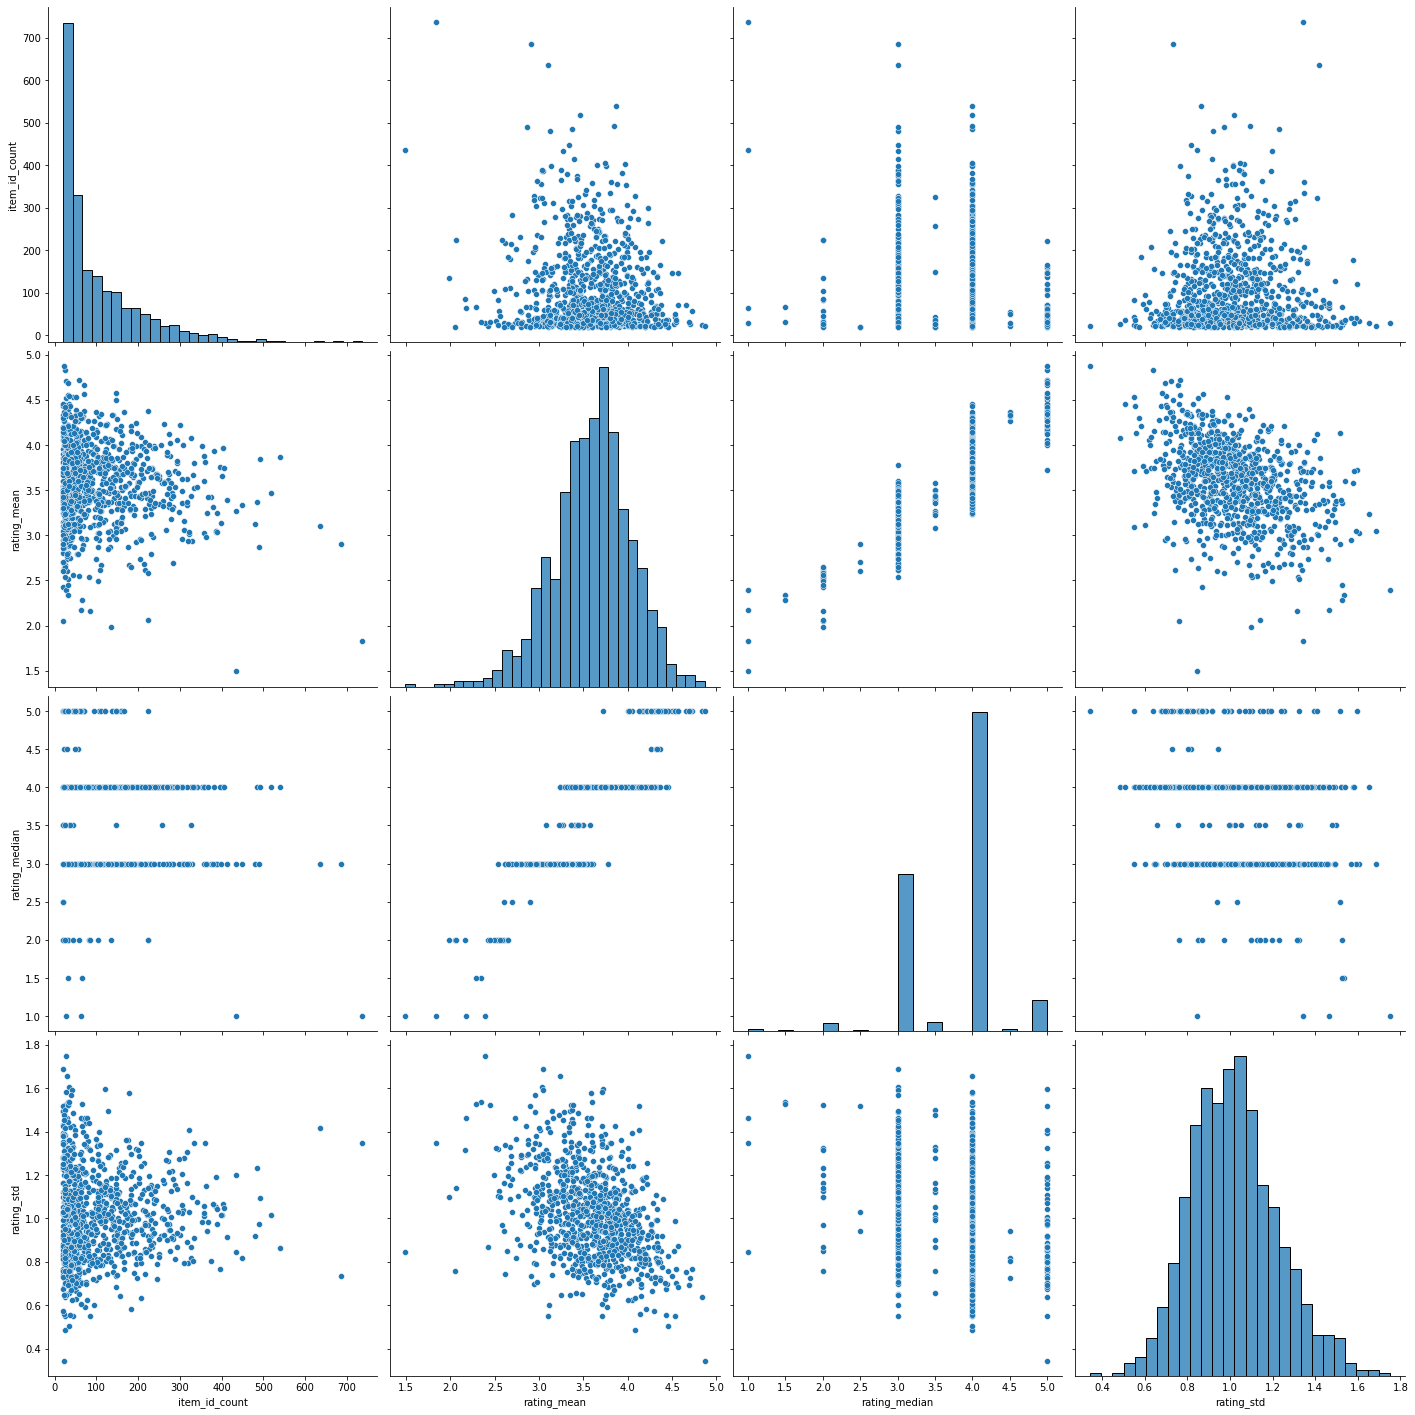

In [12]:
sns.pairplot(user_statistics, vars=['item_id_count', 'rating_mean',	'rating_median', 'rating_std'], height=5)

## features' correlations

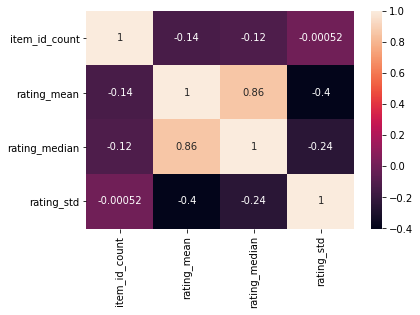

In [13]:
# only for numerical features
corr_matrix = user_statistics.corr()
sns.heatmap(corr_matrix, annot=True);

mean and median ratings are correlated. whell, ok!

## Divide numeric values into segments and make categorical feature

#### Let's create category column based on number of reviews. We will select 5 quantiles and create 4 subgroups. 

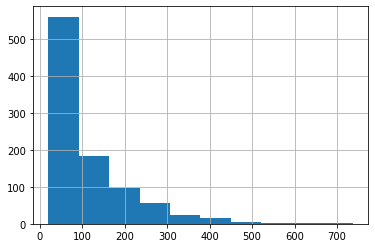

In [14]:
user_statistics['item_id_count'].hist()

In [15]:
user_statistics['reviews_count_group'] = pd.cut(user_statistics['item_id_count'], [user_statistics['item_id_count'].quantile(x) for x in [0, 0.25, 0.5, 0.75, 1]], include_lowest=True)
user_statistics.sample(3)

,item_id_count,rating_mean,rating_median,rating_std,reviews_count_group
user_id,,,,,
870,269,3.453532,4.0,0.974812,"(148.0, 737.0]"
226,50,3.800000,4.0,0.925820,"(33.0, 65.0]"
751,168,3.541667,4.0,1.071426,"(148.0, 737.0]"


#### lets build pairplot dependent on rewiews count

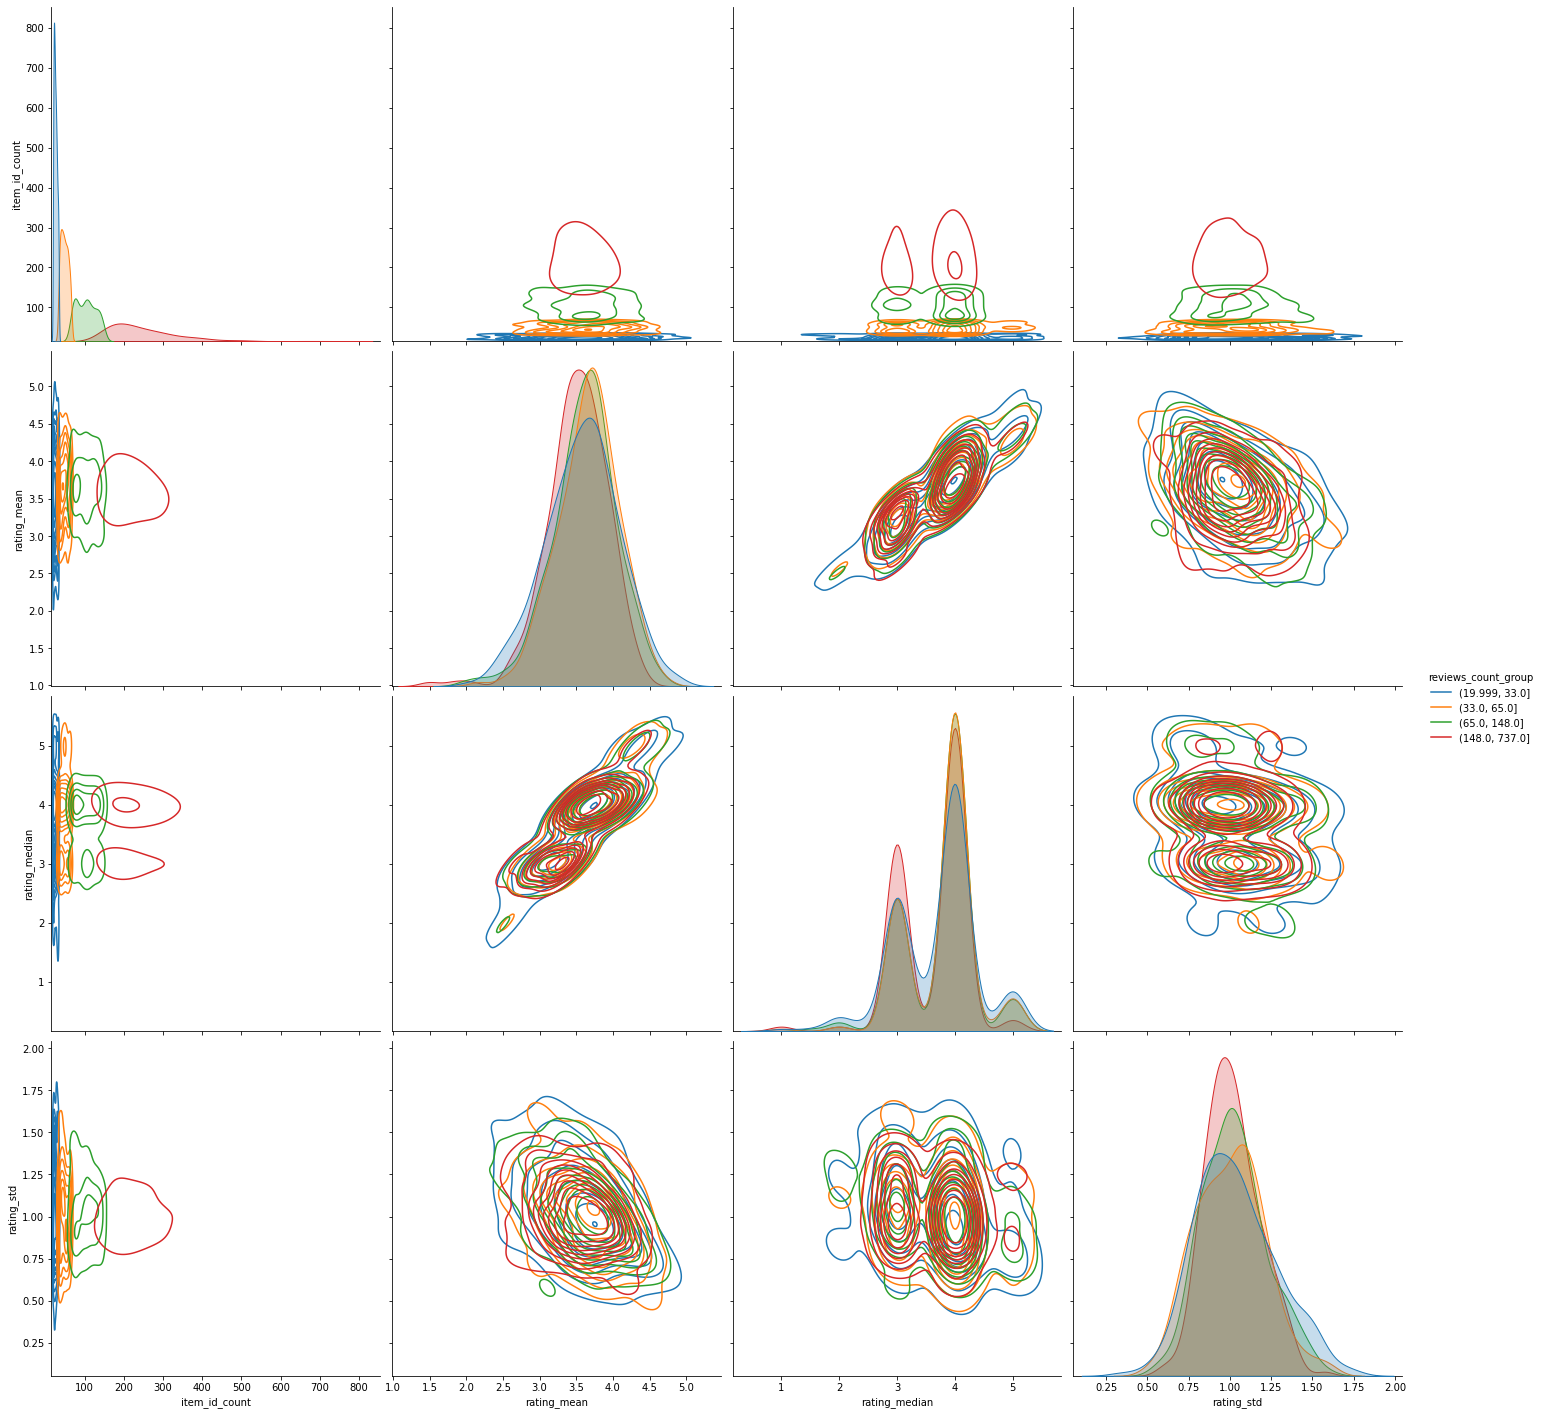

In [16]:
sns.pairplot(user_statistics, vars=['item_id_count', 'rating_mean',	'rating_median', 'rating_std'], hue='reviews_count_group', height=5, kind='kde')

Well, people don't like to rate movies at 3.5 and mean rating for users with more ratings is higher then for users with less rated movies. 

## Time features creation and analysis

#### let's process time column and create time features

In [17]:
df_log['timestamp'] = pd.to_datetime(df_log['timestamp'], unit='s')
df_log['hour'] = df_log['timestamp'].dt.hour
df_log['weekday'] = df_log['timestamp'].dt.weekday
df_log['is_weekend'] = (df_log['weekday'] >= 6).astype('int')
df_log['month'] = df_log['timestamp'].dt.month
df_log['year'] = df_log['timestamp'].dt.year
df_log['year_month'] = df_log['timestamp'].dt.to_period('M')

In [18]:
df_log.head(3)

,user_id,item_id,rating,timestamp,hour,weekday,is_weekend,month,year,year_month
0,196,242,3,1997-12-04 15:55:49,15,3,0,12,1997,1997-12
1,186,302,3,1998-04-04 19:22:22,19,5,0,4,1998,1998-04
2,22,377,1,1997-11-07 07:18:36,7,4,0,11,1997,1997-11


## Lest see how ratings correlate with date features

### year-month statistics

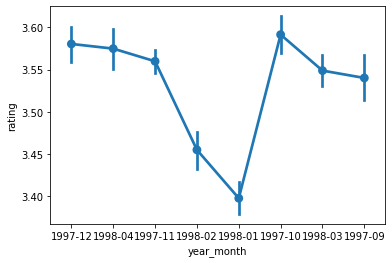

In [19]:
sns.pointplot(x="year_month", y="rating", data=df_log)

In [20]:
time_features = df_log.groupby('year_month').agg({'rating' : ['count', 'mean']})
flatten_multiindex(time_features)
time_features.head(2)

,rating_count,rating_mean
year_month,,
1997-09,6704,3.540125
1997-10,10304,3.591421


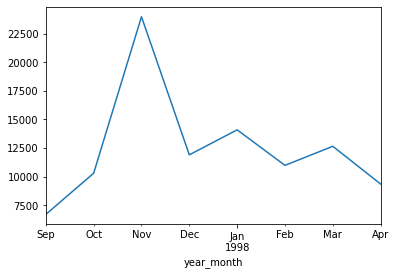

In [21]:
time_features['rating_count'].plot();

### user & year-month statistics

In [22]:
user_time_features = df_log.groupby(['user_id', 'year_month']).agg({'rating' : ['count', 'mean']})
flatten_multiindex(user_time_features)
user_time_features.reset_index(inplace=True)

In [23]:
user_time_features.groupby('year_month')['user_id'].nunique()

year_month
1997-09     80
1997-10    152
1997-11    288
1997-12    184
1998-01    219
1998-02    174
1998-03    226
1998-04    162
Freq: M, Name: user_id, dtype: int64

In [24]:
user_time_features.groupby('year_month')['rating_count'].sum()

year_month
1997-09     6704
1997-10    10304
1997-11    23980
1997-12    11911
1998-01    14095
1998-02    10991
1998-03    12656
1998-04     9359
Freq: M, Name: rating_count, dtype: int64

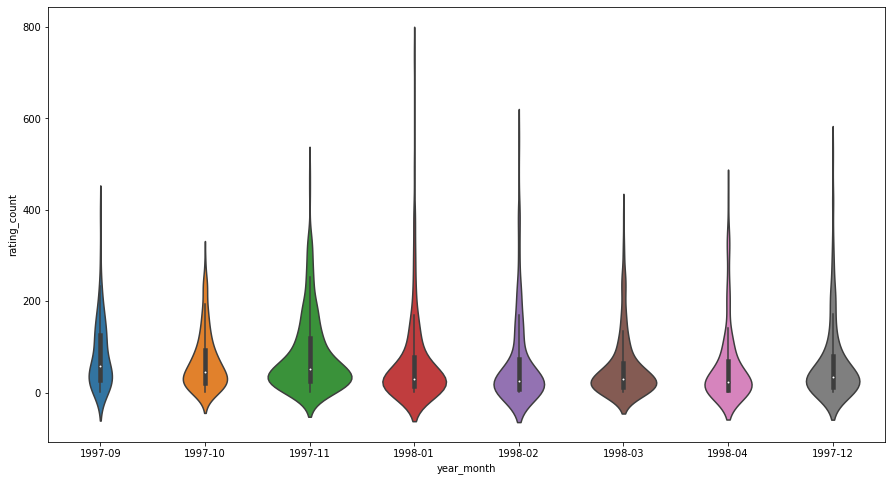

In [25]:
plt.figure(figsize=(15,8))
sns.violinplot(data=user_time_features, y='rating_count', x='year_month', scale="count")

### user & weekend statistics

In [26]:
user_time_features_weekends = df_log.groupby(['user_id', 'is_weekend']).agg({'rating' : ['count', 'mean']})
flatten_multiindex(user_time_features_weekends)
user_time_features_weekends.reset_index(inplace=True)

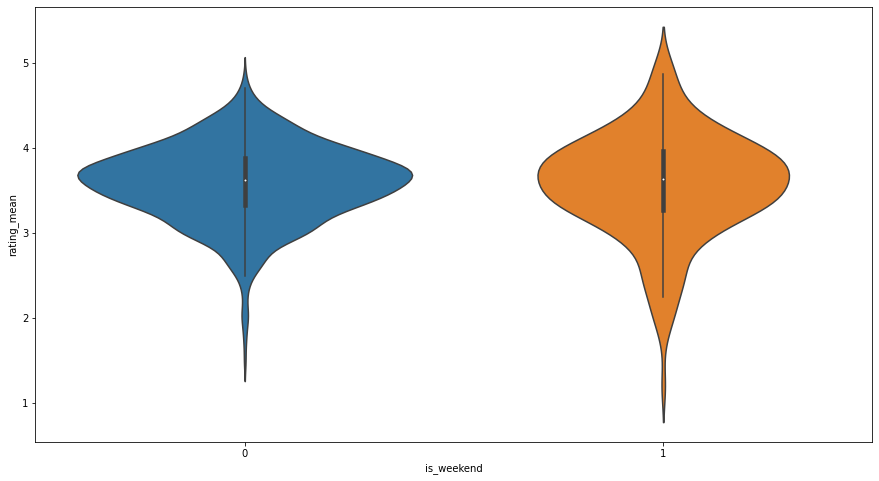

In [27]:
plt.figure(figsize=(15,8))
sns.violinplot(data=user_time_features_weekends, y='rating_mean', x='is_weekend')

# Some hints for datetime processing

## time difference

In [28]:
def calculate_timediff_in_days(series_start, series_end):
    return (series_end - series_start).dt.total_seconds() / (3600 * 24)

In [29]:
last_review_time = df_log['timestamp'].max()

df_log['user_last_rating_time'] = df_log['user_id'].map(df_log.groupby('user_id')['timestamp'].max())
df_log['user_first_rating_time'] = df_log['user_id'].map(df_log.groupby('user_id')['timestamp'].min())

In [30]:
df_log['user_lifetime_days'] = calculate_timediff_in_days(df_log['user_first_rating_time'], df_log['user_last_rating_time'])
df_log['user_absence_days'] = calculate_timediff_in_days(df_log['user_first_rating_time'], last_review_time)

In [31]:
df_log.sort_values('user_id', inplace=True)
df_log.head(10)

,user_id,item_id,rating,timestamp,hour,weekday,is_weekend,month,year,year_month,user_last_rating_time,user_first_rating_time,user_lifetime_days,user_absence_days
66567,1,55,5,1997-09-24 03:44:48,3,2,0,9,1997,1997-09,1998-03-13 01:15:36,1997-09-22 21:57:58,171.137245,212.050463
62820,1,203,4,1997-11-03 07:30:31,7,0,0,11,1997,1997-11,1998-03-13 01:15:36,1997-09-22 21:57:58,171.137245,212.050463
10207,1,183,5,1997-09-24 03:37:42,3,2,0,9,1997,1997-09,1998-03-13 01:15:36,1997-09-22 21:57:58,171.137245,212.050463
9971,1,150,5,1997-10-15 05:09:56,5,2,0,10,1997,1997-10,1998-03-13 01:15:36,1997-09-22 21:57:58,171.137245,212.050463
22496,1,68,4,1997-09-24 03:44:48,3,2,0,9,1997,1997-09,1998-03-13 01:15:36,1997-09-22 21:57:58,171.137245,212.050463
9811,1,201,3,1997-11-03 07:42:40,7,0,0,11,1997,1997-11,1998-03-13 01:15:36,1997-09-22 21:57:58,171.137245,212.050463
9722,1,157,4,1997-10-15 05:21:58,5,2,0,10,1997,1997-10,1998-03-13 01:15:36,1997-09-22 21:57:58,171.137245,212.050463
9692,1,184,4,1997-09-24 03:49:16,3,2,0,9,1997,1997-09,1998-03-13 01:15:36,1997-09-22 21:57:58,171.137245,212.050463
9566,1,210,4,1997-11-03 07:41:49,7,0,0,11,1997,1997-11,1998-03-13 01:15:36,1997-09-22 21:57:58,171.137245,212.050463
9382,1,163,4,1997-09-24 03:40:42,3,2,0,9,1997,1997-09,1998-03-13 01:15:36,1997-09-22 21:57:58,171.137245,212.050463


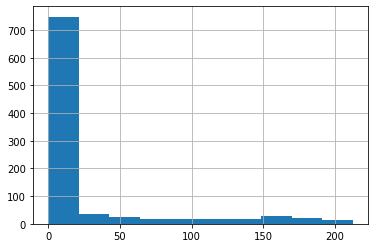

In [32]:
df_log.groupby(['user_id'])['user_lifetime_days'].max().hist()

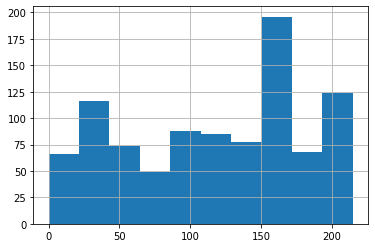

In [33]:
df_log.groupby(['user_id'])['user_absence_days'].max().hist()

## timedelta

Asume we have columns with session duration and session start time. We want to calculate session end time and find events happened during session

In [34]:
df_len = 1000

In [35]:
sessions_df = pd.DataFrame(zip(pd.date_range('2018-01-01 00:10:00', periods=df_len, freq='2H'), np.random.randint(5, 45, df_len)), columns=['session_start_time', 'session_duration'])
sessions_df['session_end_time'] = sessions_df['session_start_time'] + pd.to_timedelta(sessions_df['session_duration'], unit='m')

In [36]:
sessions_df.head(3)

,session_start_time,session_duration,session_end_time
0,2018-01-01 00:10:00,35,2018-01-01 00:45:00
1,2018-01-01 02:10:00,16,2018-01-01 02:26:00
2,2018-01-01 04:10:00,15,2018-01-01 04:25:00


In [37]:
event_start_time = pd.date_range('2018-01-01 00:10:00', '2018-01-09 18:10:10', periods=df_len * 100).round('s') + pd.to_timedelta(np.random.randint(5, 10, df_len * 100), unit='m')
events_df = pd.DataFrame(zip(event_start_time, np.random.randint(1, 5, df_len * 100)), columns=['event_start_time', 'event_duration'])
events_df['event_end_time'] = (events_df['event_start_time'] + pd.to_timedelta(events_df['event_duration'], unit='m')).round('s') 

In [38]:
print(events_df.shape)
events_df.head(3)

(100000, 3)


,event_start_time,event_duration,event_end_time
0,2018-01-01 00:15:00,2,2018-01-01 00:17:00
1,2018-01-01 00:17:08,3,2018-01-01 00:20:08
2,2018-01-01 00:19:15,2,2018-01-01 00:21:15


## events during session

In [39]:
def find_events(session, events_data=events_df):
    return events_data[(events_data['event_start_time'] < session['session_end_time'])
                    & (events_data['event_end_time'] > session['session_start_time'])].index.values

In [40]:
sessions_df['events'] = sessions_df.apply(find_events, axis=1, events_data=events_df)

In [41]:
sessions_df.head(3)

,session_start_time,session_duration,session_end_time,events
0,2018-01-01 00:10:00,35,2018-01-01 00:45:00,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,2018-01-01 02:10:00,16,2018-01-01 02:26:00,"[857, 859, 866, 873, 877, 881, 882, 883, 884, ..."
2,2018-01-01 04:10:00,15,2018-01-01 04:25:00,"[1809, 1810, 1813, 1824, 1828, 1829, 1832, 183..."


In [42]:
len(set([event for events in sessions_df['events'].values for event in events]))

22591

## aggregate overlapping events

https://stackoverflow.com/questions/57882621/efficient-merge-overlapping-intervals-in-same-pandas-dataframe-with-start-and-fi

In [43]:
events_df.sort_values('event_start_time', inplace=True)
events_df["group"] = (events_df['event_start_time'] >= events_df['event_end_time'].shift()).cumsum()

In [44]:
events_df.head(5)

,event_start_time,event_duration,event_end_time,group
0,2018-01-01 00:15:00,2,2018-01-01 00:17:00,0
4,2018-01-01 00:15:30,2,2018-01-01 00:17:30,0
10,2018-01-01 00:16:16,2,2018-01-01 00:18:16,0
3,2018-01-01 00:16:23,1,2018-01-01 00:17:23,0
13,2018-01-01 00:16:38,2,2018-01-01 00:18:38,0


In [45]:
grouped_events = events_df.groupby('group').agg({'event_start_time': min, 'event_end_time': max})
grouped_events['duration'] = (grouped_events['event_end_time'] - grouped_events['event_start_time']).dt.total_seconds() // 60
grouped_events.head(5)

,event_start_time,event_end_time,duration
group,,,
0,2018-01-01 00:15:00,2018-01-06 11:01:56,7846.0
1,2018-01-06 10:59:02,2018-01-06 11:35:19,36.0
2,2018-01-06 11:32:27,2018-01-07 00:46:43,794.0
3,2018-01-07 00:43:52,2018-01-07 17:45:04,1021.0
4,2018-01-07 17:42:13,2018-01-08 03:56:13,614.0


# Shape manipulation

## one-hot from list

In [46]:
%%time
sessions_df_onehot = pd.concat([
                                sessions_df.drop(columns='events'),
                                sessions_df['events'].apply(lambda x: pd.Series(1, x)).fillna(0)
                                ], axis=1
                               )
print(sessions_df_onehot.shape)

(1000, 22594)
CPU times: user 1.4 s, sys: 478 ms, total: 1.88 s
Wall time: 1.88 s


In [47]:
%%time
sessions_df_onehot = pd.concat([
                                sessions_df.drop(columns='events'),
                                sessions_df['events'].apply(lambda x: '|'.join(map(str, x))).str.get_dummies()
                                ], axis=1
                               )
print(sessions_df_onehot.shape)
sessions_df_onehot.shape

(1000, 22594)
CPU times: user 18.2 s, sys: 713 ms, total: 18.9 s
Wall time: 18.4 s


## explode

In [48]:
sessions_df_exploded = sessions_df.explode('events')
sessions_df_exploded.head(3)

,session_start_time,session_duration,session_end_time,events
0,2018-01-01 00:10:00,35,2018-01-01 00:45:00,0
0,2018-01-01 00:10:00,35,2018-01-01 00:45:00,1
0,2018-01-01 00:10:00,35,2018-01-01 00:45:00,2


## aggregate as a list

In [49]:
reverse_exploded = sessions_df_exploded.groupby(['session_start_time', 'session_duration', 'session_end_time'])['events'].agg(list).reset_index()
reverse_exploded.head(3)

,session_start_time,session_duration,session_end_time,events
0,2018-01-01 00:10:00,35,2018-01-01 00:45:00,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,2018-01-01 02:10:00,16,2018-01-01 02:26:00,"[857, 859, 866, 873, 877, 881, 882, 883, 884, ..."
2,2018-01-01 04:10:00,15,2018-01-01 04:25:00,"[1809, 1810, 1813, 1824, 1828, 1829, 1832, 183..."
